In [1]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((60000, 28 * 28))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((10000, 28 *28))
X_test = X_test.astype('float32') / 255

2024-02-13 15:51:43.756436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 15:51:43.756462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 15:51:43.757324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 15:51:43.762053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 15:51:44.392260: W tensorflow/compiler/tf2

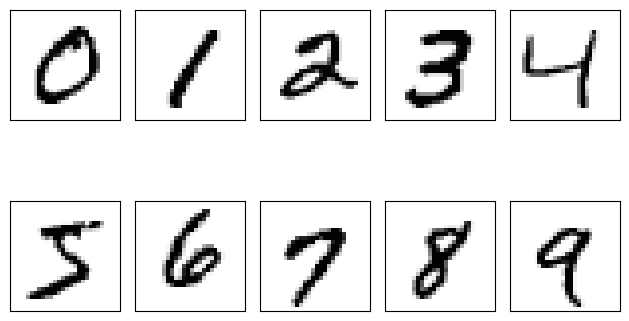

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train ==i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

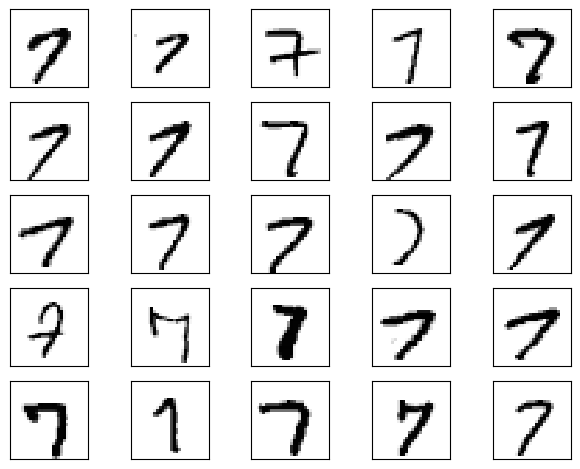

In [3]:
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output= n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    
    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:]).sum()\
                                + np.sum(w2[:, 1:] ** 2))
    
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() \
                                + np.abs(w2[:, 1:]).sum())
    
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropogation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2
    
    # def _gradient_checking(self, X, y_enc, w1,
    #                        w2, epsilon, grad1, grad2):
    #     """Apply gradient checking (for debugging only)
        
    #     Returns
    #         relative_error : float
    #             Relative error between the numerically
    #             appoximated gradients and the backpropogated gradients.
    #     """

    #     num_grad1 = np.zeros(np.shape(w1))
    #     epsilon_ary1 = np.zeros(np.shape(w1))
    #     for i in range(w1.shape[0]):
    #         for j in range(w1.shape[1]):
    #             epsilon_ary1[i, j] = epsilon
    #             a1, z2, a2, z3, a3 = self._feedforward(
    #                 X,
    #                 w1 - epsilon_ary1,
    #                 w2
    #             )
    #             cost1 = self._get_cost(y_enc,
    #                                    a3,
    #                                    w1-epsilon_ary1,
    #                                    w2)
    #             a1, z2, a2, z3, a3 = self._feedforward(
    #                 X,
    #                 w1 + epsilon_ary1,
    #                 w2
    #             )
    #             cost2 = self._get_cost(y_enc,
    #                                    a3,
    #                                    w1 + epsilon_ary1,
    #                                    w2)
    #             num_grad1[i, j] = (cost2 - cost1) / (2 * epsilon)
    #             epsilon_ary1[i, j] = 0

    #         num_grad2 = np.zeros(np.shape(w2))
    #         epsilon_ary2 = np.zeros(np.shape(w2))
    #         for i in range(w2.shape[0]):
    #             for j in range(w2.shape[1]):
    #                 epsilon_ary2[i, j] = epsilon
    #                 a1, z2, a2, z3, a3 = self._feedforward(
    #                     X,
    #                     w1,
    #                     w2 - epsilon_ary2
    #                 )
    #                 cost1 = self._get_cost(y_enc,
    #                                        a3,
    #                                        w1,
    #                                        w2 - epsilon_ary2)
    #                 a1, z3, a2, z3, a3 = self._feedforward(
    #                     X,
    #                     w1,
    #                     w2 + epsilon_ary2
    #                 )
    #                 cost2 = self._get_cost(y_enc,
    #                                        a3,
    #                                        w1,
    #                                        w2 + epsilon_ary2)
    #                 num_grad2[i, j] = (cost2 - cost1) / (2 * epsilon)
    #                 epsilon_ary2[i, j] = 0

    #             num_grad = np.hstack((num_grad1.flatten(),
    #                                   num_grad2.flatten()))
    #             grad = np.hstack((grad1.flatten(), grad2.flatten()))
    #             norm1 = np.linalg.norm(num_grad - grad)
    #             norm2 = np.linalg.norm(num_grad)
    #             norm3 = np.linalg.norm(grad)
    #             relative_error = norm1 / (norm2 + norm3)
    #             return relative_error
    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            
            #adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            
            if print_progress:
                sys.stderr.write(
                    '\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_data = X_data[idx], y_data[idx]

            mini = np.array_split(range(
                y_data.shape[0]), self.minibatches)
            for idx in mini:

                #feedforward
                a1, z2, a2, z3, a3 = self._feedforward(
                    X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                #compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)
                
                # #start graident checking
                # grad_diff = self._gradient_checking(
                #                                     X=X[idx],
                #                                     y_enc=y_enc[:, idx],
                #                                     w1=self.w1,
                #                                     w2=self.w2,
                #                                     epsilon=1e-5,
                #                                     grad1=grad1,
                #                                     grad2=grad2)
                # if grad_diff <= 1e-7:
                #     print('Ok: %s' % grad_diff)
                # elif grad_diff <= 1e-4:
                #     print('Warning: %s' % grad_diff)
                # else:
                #     print('PROBLEM: %s' % grad_diff)
                
                # #end gradient checking

                # update weights
                delta_w1, delta_w2 = self.eta * grad1,\
                                    self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [5]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=50,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [6]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1/1000

Epoch: 1000/1000

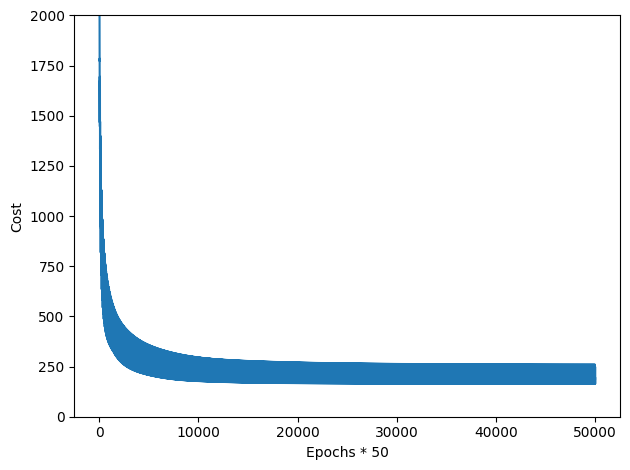

In [7]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

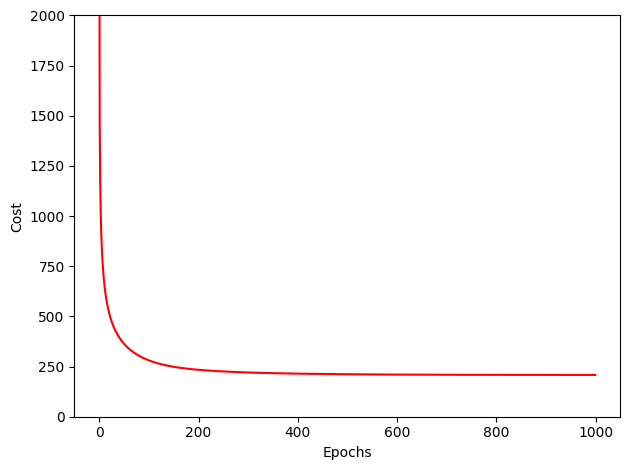

In [8]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)),
         cost_avgs,
         color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [9]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 98.87%


In [10]:
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.40%


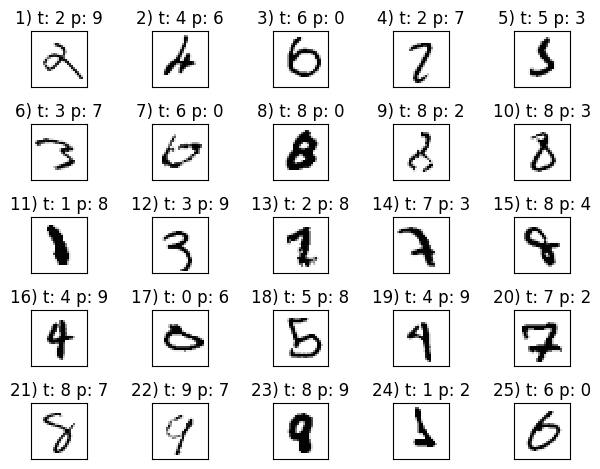

In [11]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img,
                 cmap='Greys',
                 interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d'
                    % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()